# Logistic Regression From Scratch

This notebook explains how to build, train, and evaluate a logistic regressor in Python. It covers the background and implementation of a basic logistic regressor to help understand machine learning concepts.

## Background

Logistic regression is a very simple and widely used algorithm in machine learning. It is a classification algorithm designed to predict binary outcomes based on input features. It does this by first calculating the linear combination of input features:

$$
z = \mathbf{w}^\top \mathbf{x} + b
$$

Then, it predicts the probability by passing the linear combination through the sigmoid function:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

Finally, it compares the result to a threshold, usually 0.5, to make its prediction:

$$
\hat{y} = \begin{cases} 1 & \text{if } \sigma(z) \geq 0.5 \\ 0 & \text{if } \sigma(z) < 0.5 \end{cases}
$$

The goal of logistic regression is to predict a binary outcome, or a target that can be one of two possible outcomes. It does this by determining whether or not the given input falls under the positive class.

## Step 1: Data Preparation

In order to train and test a logistic regression model, we need data with features and a target consisting of binary labels. In this example, we will generate synthetic data, but the model will work with real world data. Data preparation is split into two steps:

**1. Data Generation** - The process of creating random input features and assigning binary labels based on a hidden and randomly created linear model passed through the sigmoid function. Noise is also added to make the data more realistic.

**2. Data Splitting** - The process of splitting the generated data into training and testing sets. This allows us to see how well our model performs when predicting unseen data.

*Data Generation*

This function takes input for `samples` and `features` so we can control the length and dimensionality of the data or change the complexity. It then generates random data for features and randomly generates *true* weights and bias to calculate the resulting labels using our activation function (sigmoid).

In [44]:
import numpy as np # numeric operations

def generate_data(samples=1000, features=3):                # data generation function with input for samples and features
    X = np.random.randn(samples, features)                  # generate features randomly
    X += np.random.normal(0, 0.1, X.shape)                  # add noise
    true_weights = np.random.randn(features, 1)             # randomly generate weights
    true_bias = np.random.randn()                           # randomly generate a bias
    combination = X.dot(true_weights) + true_bias           # calculate linear combination of input and weights plus bias
    combination += np.random.normal(0, 0.1, (samples, 1))   # add noise
    probabilities = 1 / (1 + np.exp(-combination))          # calculate probabilities with sigmoid
    y = (probabilities > 0.5).astype(int)                   # convert probabilities to a binary
    return X, y                                             # return features and labels

X, y = generate_data()  # generate synthetic data

*Data Splitting*

This function takes input `X` for our features, `y` for our target, and `test_size` for the size of data. It then shuffles all possible indices of our features, determines the index to split the data on based on `test_size` and splits indices into train and test sets. Finally, it separates the target and features based on the train and test indices and returns the training and testing targets and features.

In [45]:
def split_data(X, y, test_size=0.2):
    # shuffle indices for every sample
    indices = np.arange(X.shape[0])                 # create array of possible indices
    np.random.shuffle(indices)                      # shuffle indices randomly

    # calculate index to seperate at
    split_index = int(X.shape[0] * (1 - test_size))

    # split into train/test sets
    train_indices = indices[:split_index]           # select training indices
    test_indices = indices[split_index:]            # select testing indices

    # seperate target and features into training/testing sets
    X_train = X[train_indices]                      # seperate training features
    X_test = X[test_indices]                        # seperate training target
    y_train = y[train_indices].flatten()            # seperate testing features
    y_test = y[test_indices].flatten()              # seperate training target

    return X_train, X_test, y_train, y_test         # return split dataset

X_train, X_test, y_train, y_test = split_data(X, y) # split features and target into train and test sets

## Step 2: Training Functions

Logistic regression uses four main functions while training:

**1. Sigmoid** - The function our model uses for activation

**2. Compute Loss** - The function our model uses to compute loss

**3. Predict Proba** - The function our model uses to predict the probability of a class label

**4. Parameter Initialization** - the function we use to initialize our models weights and bias with zeros

*Sigmoid*

Our sigmoid activation function takes input `z` or the linear combination of features and parameters. It then maps it to a probability between `0` and `1`. We use the sigmoid function for activation because it compresses any real number passed through it into a range of `0` to `1` which is ideal when predicting the likelihood between two classes. The function is defined as:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

In [46]:
def sigmoid(z):                 # define sigmoid function for activation
    return 1 / (1 + np.exp(-z)) # map input to range by computing sigmoid

*Compute Loss*

Our loss function uses binary cross entropy and takes input `y` for the actual target and `probs` for the probabilities of each class to measure how close the predicted label is to the actual label. The binary cross entropy function is defined as:

$$
\text{Loss}(y, \hat{y}) = - \frac{1}{N} \sum_{i=1}^{N} \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right]
$$

Where:
* $y$ is the actual label of the sample
* $\hat{y}$ is predicted probability of the positive class
* $i$ is the current sample
* $N$ is the total number of samples in the dataset

We use binary cross entropy in logistic regression because when the model is incorrect, it penalizes overconfidence more than uncertainty. This is important to logistic regression because:

1. it discourages overconfidence by heavily punishing incorrect, confident answers
2. it encourages the model to output probabilities that reflect its uncertainty
3. it improves generalization because it makes the model more cautious on unknown data

In [47]:
def compute_loss(y, probs):                                             # cross entropy function to compute loss
    eps = 1e-15                                                         # small constant to prevent errors
    probs = np.clip(probs, eps, 1 - eps)                                # clip probabilities to avoid absolutes
    return -np.mean(y * np.log(probs) + (1 - y) * np.log(1 - probs))    # return average log loss over every sample

*Predict Probability*

This function takes input `X` for the features, `weights` for the current weights, and `bias` for the current bias. The function works by first computing the linear combination of the features using the current weight and bias using the following equation:

$$
z = \mathbf{w}^\top \mathbf{x} + b
$$

Then the function passes the combination through the activation function (sigmoid) to compress it into a value between **0** and **1**. This value represents the models confidence that the class is positive for the given features.

In [48]:
def predict_proba(X, weights, bias):        # calculate label probabilty
    combination = np.dot(X, weights) + bias # calculate linear combination
    return sigmoid(combination)             # caclulate and return probability

*Parameter Initialization*

Before we can train the model, we need to initialize the parameters that will be updated during gradient descent. The function takes input `X` for our input data. It then initializes our models weights and bias with zeros, using the shape of our input data to determine the amount of weights.

In [49]:
def parameter_initialization(X):    # function to initialize model parameters
    weights = np.zeros(X.shape[1])  # initialize a weight for each feature
    bias = 0.0                      # initialize bias
    return weights, bias            # return zeroed weights and bias

weights, bias = parameter_initialization(X_train)   # initialize zeroed weights and bias

## Step 3: Model Training

To train our model, we implemented the `train` function, which uses gradient descent to optimize our model. Our function has the following inputs:

* `X` - our training features
* `y` - our training data
* `weights` - the current model weights
* `bias` - the current model bias
* `epochs` - the amount of training epochs or iterations
* `learning_rate` - the constant controlling the size of each update

The function begins by initializing two lists, `loss_history` and `error_history`, these are used to record the loss and average error of our model over each epoch, or iteration of training. Then the training loop begins iterating once for every epoch. It is broken into five steps:

**1. Forward pass**
The model calls the `predict_proba` function with the training features and the current weights and bias. This gives us the models predicted probability of the positive class based on the current sample.

**2. Loss Calculation**
The model begins by calling `compute_loss` to compare the predicted probabilities with the true labels. Then it calculates the average error by taking the average of the true values subtracted from the predicted ones. Finally, it appends loss and average error to their respective histories.

**3. Backpropagation**
The model then calculates the gradient of the loss with respect to the weights and the gradient of the loss with respect to the bias.

**4. Update Parameters**
Now we update the weights and bias using gradient descent by multiplying their gradients by the learning rate and then subtracting that from them.

**5. Progress Logging**
if the total number of epochs is greater than or equal to 10 and the current epoch is a tenth interval of the total, it logs the current epoch and the loss so we can monitor progress.

After all epochs are completed, the function returns the updated weights, updated bias, loss history, and the error history.

In [50]:
def train(X, y, weights, bias, epochs = 1000, learning_rate = 0.1): # train the model using gradient descent
    # initialize history
    loss_history = []                                               # store loss history for each epoch
    error_history = []                                              # store error history for each epoch

    # training loop
    for epoch in range(epochs): # begin training, iterating for each epoch
        # forward pass
        probs = predict_proba(X, weights, bias) # predict probability for each sample

        # loss and error calculation
        loss = compute_loss(y, probs)   # calcuate loss using binary cross entropy
        error = probs - y               # calculate prediction error
        average_error = np.mean(error)

        # save to history
        loss_history.append(loss)
        error_history.append(average_error)

        # backpropagation (backwards pass or gradient descent)
        gradient_weights = np.dot(X.T, error) / len(y)  # calculate gradient for the weights
        gradient_bias = average_error                   # set gradient for bias (same calcuation as earlier)

        # parameter updates
        weights -= learning_rate * gradient_weights # update weights with gradient descent
        bias -= learning_rate * gradient_bias       # update bias with gradient descent

        # progress
        if epochs >= 10 and epoch % (epochs // 10) == 0:    # print progress every tenth of epochs
            print(f"Epoch {epoch}, Loss: {loss:.2f}")

    return weights, bias, loss_history, error_history   # return updated parameters and history

learned_weights, learned_bias, loss_history, error_history = train(X_train, y_train, weights, bias) # train model

Epoch 0, Loss: 0.69
Epoch 100, Loss: 0.27
Epoch 200, Loss: 0.21
Epoch 300, Loss: 0.18
Epoch 400, Loss: 0.16
Epoch 500, Loss: 0.14
Epoch 600, Loss: 0.13
Epoch 700, Loss: 0.13
Epoch 800, Loss: 0.12
Epoch 900, Loss: 0.12


## Step 4: Predict


The predict function is used to generate final predictions as a binary. It has input for:


* `X` - the input features to predict for
* `weights` - the trained model weights
* `bias` - the trained model bias
* `threshold` - the probability cutoff between classes


The function works by calculating the linear combination, applying the activation function to the combination, then applying the threshold to the prediction.

In [51]:
def predict(X, weights, bias, threshold = 0.5):         # use weights and bias to predict labels
    z = np.dot(X, weights) + bias                       # calculate linear combination
    probability = sigmoid(z)                            # use sigmoid activation to predict probability
    return (probability >= threshold).astype(int)       # convert probabilities to binary comparing to threshold

predictions = predict(X_test, learned_weights, learned_bias)    # predict testing data

## Step 5: Evaluate

You can evaluate a logistic regressor using the accuracy score, which tells us how often our model predicts the correct class. Accuracy score is calculated using the following equation:

$$
\text{Accuracy} = \frac{1}{n} \sum_{i=1}^{n} \mathbb{1}(\hat{y}_i = y_i)
$$

Where:
* $\hat{y}_i$ is the predicted label
* $y_i$ is the true label
* $\mathbb{1}$ is the indicator function returning 1 if true and 0 if false
* $n$ is the number of samples

In [52]:
def score(predictions, actual):             # calculate accuracy by comparing predictions vs actual
    return np.mean(predictions == actual)   # return proportion of correct predictions

accuracy = score(predictions, y_test)           # score model
print(f"Accuracy Score: {accuracy*100:.2f}%")   # print score

Accuracy Score: 96.00%


**Loss Plot**

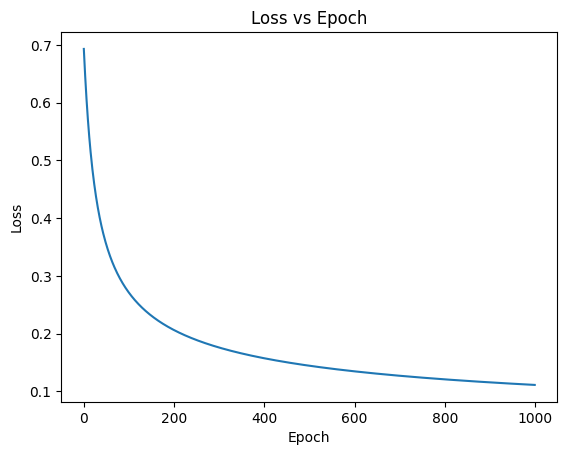

In [53]:
import matplotlib.pyplot as plt # for making graphs

plt.plot(loss_history)          # plot losses
plt.title("Loss vs Epoch")      # add title
plt.ylabel("Loss")              # y axis label
plt.xlabel("Epoch")             # x axis label
plt.show()                      # display plot


**Average Error Plot**

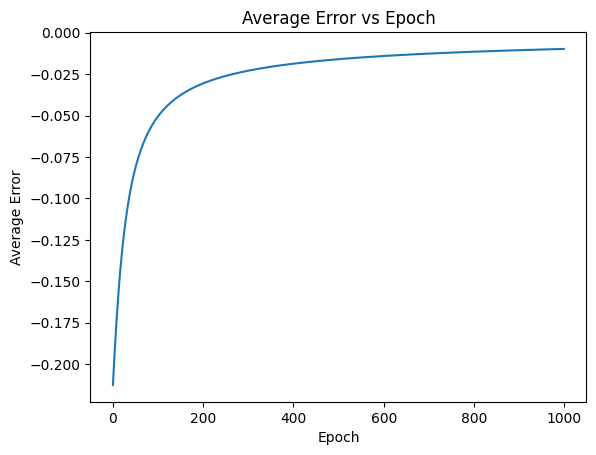

In [54]:
plt.plot(error_history)             # plot average errors
plt.title("Average Error vs Epoch") # add title
plt.ylabel("Average Error")         # add x label
plt.xlabel("Epoch")                 # add y label
plt.show()                          # print

## Author and Liscense

This notebook was authored by Aiden Flynn and is available under the [Apache 2.0](https://www.apache.org/licenses/LICENSE-2.0.txt) Liscense.

[Kaggle](https://www.kaggle.com/flynn28) | [Github](https://github.com/flynn-28/)